In [1]:
import torch
import torch.nn as nn
from hyperparams_and_args import get_argparser, data_dir
from ninolearn.IO.read_processed import data_reader

from data_handling.data_handler_CNN_data import IndexLoader
from GNN_model1.train_single_step import main, evaluate, evaluate_index
from plotting import plot_time_series, heatmap_of_edges
from utils import read_ssta
import warnings
warnings.filterwarnings("ignore")  # or use: "once"

In [2]:
model_dir = "models/exp1/"

In [3]:
train_dates=("1871-01", "1972-12")
val_dates=("1973-01", "1983-12")
test_dates=("1984-01", "2020-08")
parser = get_argparser(experiment="ERSSTv5")
args = parser.parse_args("")
args.data_dir = data_dir
args.batch_size = 32
args.resolution = 5
args.lon_min = 190
args.lon_max = 240
args.lat_min = -5
args.lat_max = 5
args.window = 3
args.epochs = 150
args.layers = 2
args.lr = 1e-4
args.prelu = True
args.dropout = 0.1

In [4]:
def train_exp1(args, reader):
    print(f"#Lead months = {args.horizon}, #layers = {args.layers}, Inputs between "
          f"{args.lat_min} to {args.lat_max} latitude and {args.lon_min} to {args.lon_max} longitude "
          f"for the past {args.window} months")

    flattened_ssta, train_mask = read_ssta(data_dir=args.data_dir, index=args.index, get_mask=True, resolution=args.resolution, reader=reader)
    args.mask = train_mask

    print("Model will be saved in", args.save)
    main(args, adj=None, train_dates=train_dates, val_dates=val_dates, test_dates=test_dates)  # learn edges


In [5]:
def eval_model(args):
    model = torch.load(args.save)
    model.eval()

    evaluateL2 = nn.MSELoss().to(args.device)
    evaluateL1 = nn.L1Loss().to(args.device)

    Data = IndexLoader(args, test_set="ERSSTv5", start_date="1984-01", end_date="2020-08", data_dir=data_dir)
    test_acc, test_rae, test_corr, oni_test_stats, preds, Ytrue = evaluate(Data, Data.test[0], Data.test[1],
                                                                               model, evaluateL2, evaluateL1, args,
                                                                               return_oni_preds=True)
    print("Exp1 Test stats... OVERALL: rse {:5.4f} , RMSE {:5.4f} , corr {:5.4f}"
                    " | ONI:  RMSE {:5.4f} , corr {:5.4f}"
          .format(test_acc, test_rae, test_corr, oni_test_stats["RMSE"], oni_test_stats["Corrcoef"]))
    return preds, Ytrue, Data.semantic_time_steps

In [6]:
def train_and_eval(args):
    reader = data_reader(data_dir=data_dir,
                         startdate=train_dates[0], enddate=test_dates[1],
                         lon_min=args.lon_min, lon_max=args.lon_max,
                         lat_min=args.lat_min, lat_max=args.lat_max)

    train_exp1(args, reader=reader)

    # Eval test scores
    preds, Y, time_axis = eval_model(args)

    # Plot learned edges
    heatmap_of_edges(file_path=args.save, args=args, reader=reader, index=args.index, min_weight=1e-4,
                     data_dir=args.data_dir, only_towards_oni_region=True)

    # PLot ONI timeseries
    oni_preds, oni_Y = preds.mean(axis=1), Y.mean(axis=1)
    plot_time_series(oni_Y, oni_preds, time_steps=time_axis, labels=["ERSSTv5 ONI", "GNN Forecast"],
                     ylabel=f"{args.index} index",  save_to=None)


#Lead months = 1, #layers = 2, Inputs between -5 to 5 latitude and 190 to 240 longitude for the past 3 months
Model will be saved in models/exp1/1mon_lead
Time series Length = 1222, Number of nodes = 33, Predict 1 time steps in advance using 3 time steps, Training set size = 1222  

The receptive field size is 19
Number of model parameters is 27969
begin training
--> Epoch   1 | time:  2.67s | train_loss 0.9177 | Val. loss 0.0099, corr 0.4592 | ONI corr 0.5151, RMSE 0.3046
Model will be saved...
--> Epoch   2 | time:  1.64s | train_loss 0.5658 | Val. loss 0.0096, corr 0.8905 | ONI corr 0.8998, RMSE 0.2966
Model will be saved...
--> Epoch   3 | time:  1.63s | train_loss 0.3341 | Val. loss 0.0052, corr 0.8836 | ONI corr 0.8889, RMSE 0.1450
Model will be saved...
--> Epoch   4 | time:  1.67s | train_loss 0.1823 | Val. loss 0.0058, corr 0.8967 | ONI corr 0.9010, RMSE 0.1691
--> Epoch   5 | time:  1.62s | train_loss 0.1237 | Val. loss 0.0041, corr 0.9306 | ONI corr 0.9341, RMSE 0.1160
Model

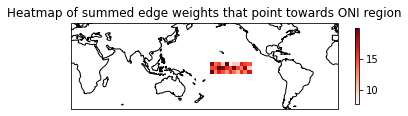

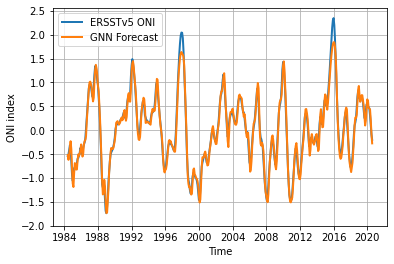

In [7]:
args.horizon = 1
args.epochs = 25
args.save = model_dir + "1mon_lead"
train_and_eval(args)

#Lead months = 3, #layers = 2, Inputs between -5 to 5 latitude and 190 to 240 longitude for the past 3 months
Model will be saved in models/exp1/3mon_lead
Time series Length = 1222, Number of nodes = 33, Predict 3 time steps in advance using 3 time steps, Training set size = 1222  

The receptive field size is 19
Number of model parameters is 27969
begin training
--> Epoch   1 | time:  7.64s | train_loss 0.4748 | Val. loss 0.0082, corr 0.8120 | ONI corr 0.8290, RMSE 0.2491
Model will be saved...
--> Epoch   2 | time:  7.65s | train_loss 0.3250 | Val. loss 0.0054, corr 0.8186 | ONI corr 0.8319, RMSE 0.1530
Model will be saved...
--> Epoch   3 | time:  7.77s | train_loss 0.2748 | Val. loss 0.0050, corr 0.8476 | ONI corr 0.8632, RMSE 0.1404
Model will be saved...
--> Epoch   4 | time:  7.68s | train_loss 0.2504 | Val. loss 0.0048, corr 0.8694 | ONI corr 0.8872, RMSE 0.1354
Model will be saved...
--> Epoch   5 | time:  7.68s | train_loss 0.2355 | Val. loss 0.0046, corr 0.8788 | ONI corr 0.

+++++++++++++++++++++  BEST MODEL STATS (best w.r.t to validations RMSE): +++++++++++++++++++++++++++++++
-------> Valid stats: rse 0.0039 | rae 0.0000 | corr 0.9061 | ONI corr 0.9234 | ONI RMSE 0.1026
-------> Test stats: rse 0.0074 | rae 0.0001 | corr 0.8758 | ONI corr 0.8935 | ONI RMSE 0.2043
Saved in models/exp1/3mon_lead_33nodes.pt
Exp1 Test stats... OVERALL: rse 0.0125 , RMSE 0.0003 , corr 0.8807 | ONI:  RMSE 0.3432 , corr 0.8987
# Nonzero Edges: 520


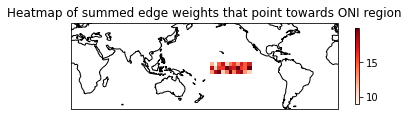

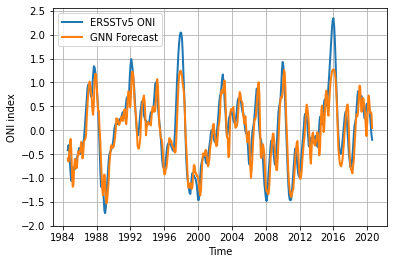

In [8]:
args.horizon = 3
args.epochs = 50
args.save = model_dir + "3mon_lead"
train_and_eval(args)